# Minas Fakhori - CI603 Assignment

## **Naïve Bayes Classifier**


TODO: Write something about it 

### Step 1 - Install & Import the packages

In [1]:
%pip install pyspark --quiet
%pip install setuptools --quiet
%pip install matplotlib --quiet
%pip install pandas --quiet
%pip install seaborn --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, array_max, when,array_max, count

from pyspark.ml import Pipeline
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.functions import vector_to_array

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from enum import Enum

### Step 2 - Start the spark session and load the files

In [4]:
spark = SparkSession.builder.appName("diabetes").master("local[3]").getOrCreate() # local[3] means running locally with 3 cores

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/05/26 23:03:19 WARN Utils: Your hostname, minas-linux, resolves to a loopback address: 127.0.1.1; using 192.168.1.3 instead (on interface wlo1)
25/05/26 23:03:19 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/26 23:03:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
df = spark.read.csv("../data/diabetes_dataset.csv", header=True, inferSchema=True)

In [6]:
df.show(10)

+------------+------+--------+---------+----+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+----+---------+------+
|Diabetes_012|HighBP|HighChol|CholCheck| BMI|Smoker|Stroke|HeartDiseaseorAttack|PhysActivity|Fruits|Veggies|HvyAlcoholConsump|AnyHealthcare|NoDocbcCost|GenHlth|MentHlth|PhysHlth|DiffWalk|Sex| Age|Education|Income|
+------------+------+--------+---------+----+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+----+---------+------+
|         0.0|   1.0|     1.0|      1.0|40.0|   1.0|   0.0|                 0.0|         0.0|   0.0|    1.0|              0.0|          1.0|        0.0|    5.0|    18.0|    15.0|     1.0|0.0| 9.0|      4.0|   3.0|
|         0.0|   0.0|     0.0|      0.0|25.0|   1.0|   0.0|                 0.0|         1.0|   0.0|    0.0|              0.0|          0.0|    

### Step 3 - Change all the data to binary and remove columns

In [7]:
bin_diabetes = df.withColumn("Diabetes", when(col("Diabetes_012") > 1.0, 1.0).otherwise(0.0))
bin_bmi = bin_diabetes.withColumn("Healthy weight", when(col("BMI") < 18.5, 0.0).when((col("BMI") >= 18.5) & (col("BMI") < 25.0), 1.0).when((col("BMI") >= 25.0) & (col("BMI") < 30.0), 0.0).otherwise(1.0)
)
bin_income = bin_bmi.withColumn("Good_Income", when(col("Income") < 6.0, 0.0).otherwise(1.0))
bin_health = bin_income.withColumn("GenHlth", when(col("GenHlth") > 3.0, 0.0).otherwise(1.0))
bin_degree = bin_health.withColumn("Degree", when(col("Education") < 5.0, 0.0).otherwise(1.0))
bin_df = bin_degree.withColumn("Old", when(col("Age") < 9.0, 0.0).otherwise(1.0))


In [8]:
bin_df = bin_df.drop("Diabetes_012", "BMI", "Education", "Income", "Age")
bin_df = bin_df.drop("MentHlth", "PhysHlth") # These are for the last 30 days, which isn't enough information to be useful

In [9]:
bin_df.show(10)

+------+--------+---------+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+---+--------+--------------+-----------+------+---+
|HighBP|HighChol|CholCheck|Smoker|Stroke|HeartDiseaseorAttack|PhysActivity|Fruits|Veggies|HvyAlcoholConsump|AnyHealthcare|NoDocbcCost|GenHlth|DiffWalk|Sex|Diabetes|Healthy weight|Good_Income|Degree|Old|
+------+--------+---------+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+---+--------+--------------+-----------+------+---+
|   1.0|     1.0|      1.0|   1.0|   0.0|                 0.0|         0.0|   0.0|    1.0|              0.0|          1.0|        0.0|    0.0|     1.0|0.0|     0.0|           1.0|        0.0|   0.0|1.0|
|   0.0|     0.0|      0.0|   1.0|   0.0|                 0.0|         1.0|   0.0|    0.0|              0.0|          0.0|        1.0|    1.0|     0.0|0.0|     0.0|           0.0|        0

### Step 4 - Preprocess Data including balance and view.

In [10]:
Balancing_Techniques = Enum('Balancing_Techniques', [('OverSample', 1), ('UnderSample', 2), ('WeightBalance', 3)])

In [11]:
def plot_pie_chart(df, column, labels_arr):
    pandas_df = df.select(column).groupBy(column).count().toPandas()

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    
    pandas_df.plot(
        kind="pie",
        y="count",
        legend=False,
        autopct="%1.1f%%",
        labels=labels_arr,
        ax=axes[0]
    ).set_ylabel("")
    axes[0].set_title(f"{column} Distribution (Pie)")

    

    pandas_df.plot(
        kind="bar",
        x=column,
        y="count",
        legend=False,
        ax=axes[1],
    )
    axes[1].set_title(f"{column} Distribution (Bar)")
    axes[1].set_xticklabels(labels_arr, rotation=0)
    axes[1].set_xlabel(column)
    axes[1].set_ylabel("Count")


    plt.show()


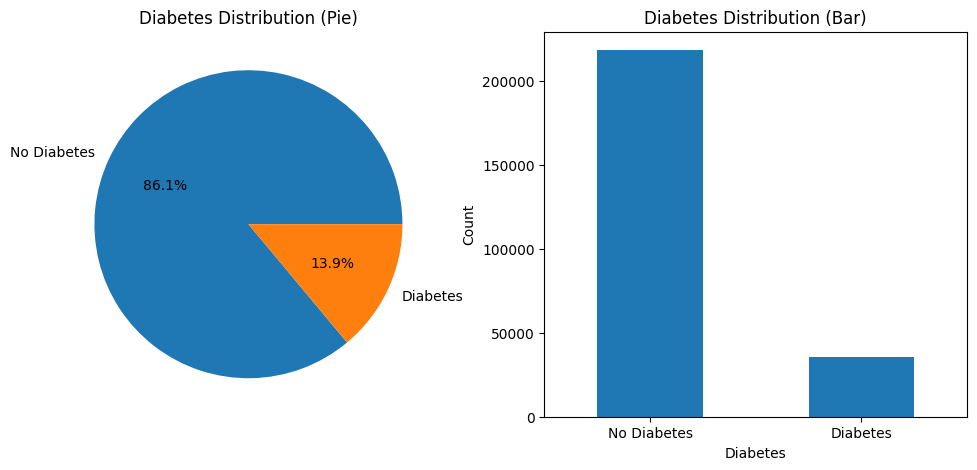

In [12]:
plot_pie_chart(bin_df, "Diabetes", ["No Diabetes", "Diabetes"])

**Under Sampling** to make the same outputs balanced

In [13]:
def under_sample(df, class_col): 

    class_distribution = df.groupBy(class_col).count().collect()
    class_counts = {row[class_col]: row["count"] for row in class_distribution} 


    min_class = min(class_counts, key=class_counts.get)
    max_class = max(class_counts, key=class_counts.get)
    min_count = class_counts[min_class]


    df_min = df.filter(col(class_col) == min_class)
    df_max = df.filter(col(class_col) == max_class)


    sampling_fraction = min_count / class_counts[max_class]

    sampling_fraction = min(sampling_fraction, 1.0) # this makes sure that the fraction is not greater than 1

    df_max_sampled = df_max.sample(withReplacement=False, fraction=sampling_fraction)

    df_undersampled = df_min.union(df_max_sampled)

    return df_undersampled


In [14]:
def over_sample(df, class_col):
    class_distribution = df.groupBy(class_col).count().collect()
    class_counts = {row[class_col]: row["count"] for row in class_distribution}


    min_class = min(class_counts, key=class_counts.get)
    max_class = max(class_counts, key=class_counts.get)
    max_count = class_counts[max_class]


    df_min = df.filter(col(class_col) == min_class)
    df_max = df.filter(col(class_col) == max_class)


    oversampling_fraction = max_count / class_counts[min_class]


    df_min_oversampled = df_min.sample(withReplacement=True, fraction=oversampling_fraction)

    df_oversampled = df_min_oversampled.union(df_max)

    return df_oversampled


In [15]:
def weight_balance(df, class_col):
    class_counts = df.groupBy(class_col).count().toPandas().set_index(class_col)["count"]
    min_class = class_counts.idxmin()
    max_count = class_counts.max()
    min_count = class_counts.min()
    weight = max_count / min_count

    
    df = df.withColumn(
        "weight",
        when(col(class_col) == float(min_class), weight).otherwise(1.0)
    )
    return df


In [16]:
def balance_data(df, class_col, balancing_technique):
    if balancing_technique == Balancing_Techniques.OverSample:
        df = over_sample(df, class_col)
        return df
    elif balancing_technique == Balancing_Techniques.UnderSample:
        df = under_sample(df, class_col)
    elif balancing_technique == Balancing_Techniques.WeightBalance:
        df = weight_balance(df, class_col)
    return df


In [17]:
balance_data = balance_data(df=bin_df, class_col="Diabetes", balancing_technique=Balancing_Techniques.WeightBalance)

if "weight" in balance_data.columns:
    balance_data.show(50)
else: 
    plot_pie_chart(balance_data, "Diabetes", ["No Diabetes", "Diabetes"])

+------+--------+---------+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+---+--------+--------------+-----------+------+---+-----------------+
|HighBP|HighChol|CholCheck|Smoker|Stroke|HeartDiseaseorAttack|PhysActivity|Fruits|Veggies|HvyAlcoholConsump|AnyHealthcare|NoDocbcCost|GenHlth|DiffWalk|Sex|Diabetes|Healthy weight|Good_Income|Degree|Old|           weight|
+------+--------+---------+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+---+--------+--------------+-----------+------+---+-----------------+
|   1.0|     1.0|      1.0|   1.0|   0.0|                 0.0|         0.0|   0.0|    1.0|              0.0|          1.0|        0.0|    0.0|     1.0|0.0|     0.0|           1.0|        0.0|   0.0|1.0|              1.0|
|   0.0|     0.0|      0.0|   1.0|   0.0|                 0.0|         1.0|   0.0|    0.0|              0.0|        

### Step 5 - Create the Naïve Bayes Classifier

In [18]:
feature_columns = [col for col in balance_data.columns if col != "Diabetes" and col != "weight"] # All columns except the outcome (Diabetes) and (weight)
vector = VectorAssembler(inputCols=feature_columns, outputCol="features")
stringIndexer = StringIndexer(inputCol="Diabetes", outputCol="label")


In [19]:
if "weight" in balance_data.columns:
    NB=NaiveBayes(featuresCol="features",labelCol="label",weightCol="weight")
else:
    NB=NaiveBayes(modelType="bernoulli", featuresCol="features",labelCol="label")

In [20]:
pipeline = Pipeline(stages=[stringIndexer, vector, NB])

In [21]:
(train_data,test_data)=balance_data.randomSplit([0.8,0.2])
pipelineModel=pipeline.fit(train_data)
predictions = pipelineModel.transform(test_data)

25/05/26 23:03:30 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


### Step 6 - Reorder the df to get the highest Probability outcomes

In [22]:
reorder_hightest = predictions.withColumn(
	"max_probability", array_max(vector_to_array(col("probability")))
).orderBy(col("max_probability").desc())

In [23]:
reorder_hightest.show(10, truncate=False)

+------+--------+---------+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+---+--------+--------------+-----------+------+---+-----------------+-----+-------------------------------------------------------------------------------+-----------------------------------------+-----------------------------------------+----------+------------------+
|HighBP|HighChol|CholCheck|Smoker|Stroke|HeartDiseaseorAttack|PhysActivity|Fruits|Veggies|HvyAlcoholConsump|AnyHealthcare|NoDocbcCost|GenHlth|DiffWalk|Sex|Diabetes|Healthy weight|Good_Income|Degree|Old|weight           |label|features                                                                       |rawPrediction                            |probability                              |prediction|max_probability   |
+------+--------+---------+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+---+---

### Step 7 - Evaluate the output

In [24]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
accuracy = evaluator.evaluate(predictions)
percentage = round(accuracy, 4) * 100

print(f"Test set accuracy = {percentage}%")

Test set accuracy = 73.87%


In [25]:
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1"
)


f1 = evaluator_f1.evaluate(predictions)


print(f"F1 Score: {round(f1, 4)}")


F1 Score: 0.7734


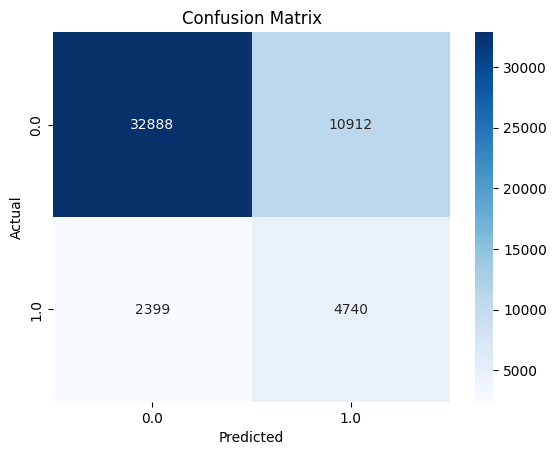

In [26]:
pandas_df = predictions.select("label", "prediction").toPandas()

confusion_matrix = pd.crosstab(pandas_df["label"], pandas_df["prediction"], rownames=["Actual"], colnames=["Predicted"])
 
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()
